In [10]:
#!/usr/bin/env python
# coding: utf-8

import sys, os, array, time
import numpy as np
import serial, math, secrets
from random import *
from ast import literal_eval
import struct
import tensorflow as tf
from tensorflow import keras
from serial import Serial

from matplotlib import pyplot as plt

In [11]:
# Timer for calculating inferance time
class timer:
    def __init__(self, name=None):
        self.name = name

    def tic(self):
        self.T_start = time.time()

    def toc(self):
        self.T_stop = time.time()
        print("Elapsed time: " + str(self.T_stop - self.T_start) + " s")

In [12]:
def perso_model_prediction(model, input_values, summary=False):
    # Load an already existing model and test its outputs
    to_be_tested_model = tf.keras.models.load_model(model)

    if summary == True:
        to_be_tested_model.summary()
        for layers in to_be_tested_model.layers:
            print(layers.kernel)

    # add reshape
    output_pred = to_be_tested_model.predict(input_values.reshape(-1,64,64,3))
    return output_pred

In [15]:
class MODEL_set:
    def __init__(self, used_model):
        self.used_model = used_model

        self.x_sample = -1
        self.y_sample = -1

        #we have 4 labels
        self.received_output = np.zeros((1,4)) 
        #self.received_categories = np.zeros((3))

    def set_dataset_from_xtest(self, path_xtest, path_ytest):
        self.X_test = np.load(path_xtest).astype(dtype=np.float32)
        self.Y_test = np.load(path_ytest).astype(dtype=np.float32)

    def pick_rand_value_from_xtest(self):
        rand_sample = randint(0, self.X_test.shape[0]-1)
        self.x_sample = self.X_test[rand_sample]
        self.y_sample = self.Y_test[rand_sample]
        # return l'indice du grand élement dans y_samp càd 0
        tmp = self.y_sample.argmax(axis=0)
        print("Chosen input's corresponding label is "+str(tmp)+" according to y_test")

    def get_prediction(self):
        print(self.x_sample.shape)
        tmp_proba = perso_model_prediction(self.used_model, self.x_sample)
        self.y_proba = tmp_proba
        # __j'ai changé axis =0 to axis=1
        tmp = self.y_proba.argmax(axis=0) 
        print("\nPYTHON:")
        print("Model prediction is "+str(tmp)+" with probability "+str(self.y_proba[tmp]))
        
    def categorize_received_output(self):
        print ("STM32:")
        print ("Obtained probabilities: \n" + str(self.received_output.round(decimals=4)))
        index = self.received_output.argmax(axis=1) # index = 0
        print ("Model prediction is "+str(index)+" with probability "+str(self.received_output[0][index])+"\n")

        if (self.y_sample.argmax(axis=0) != index):
            print ("***** Prediction does not match with y_test label")
        else:
            print ("***** Prediction matches with y_test label")

    def match_pred_label(self):
        if (self.y_sample.argmax(axis=0) != self.received_output.argmax(axis=1)): # __j'ai changé axis=0 to axis=1
            return 1
        else:
            return 0



In [16]:
def synchronisation_with_target(debug=False):
    sync = False
    ret = None

    while (sync == False):
        ser.write(b"sync")
        ret = ser.read(3)
        if (ret == b"101"): # "101" has been chosen arbitrarily
            sync = True
            if (debug):
                print("Synchronised")
        else:
            if (debug):
                print ("Wrong ack reponse")


In [17]:
def send_NN_inputs_to_STM32(MODEL_set, ser):
    if not ser.isOpen():
        print ("Error: serial connection to be used isn't opened")
        sys.exit(-1)

    # Synchronisation loop
    print("trying to sync...\n")
    synchronisation_with_target(True) #Debug mode
    
    # Send inputs to the Neural Network
    input_sent = False
    # empty serial buffer
    ser.flush()

    tmp = MODEL_set.x_sample.reshape(64,64,3)
    plt.imshow(tmp)
    plt.title("Image sent to STM32")
    plt.show()
    while(input_sent == False):
        
    # rgb processing
        for k in range(3):
            for i in range(64):
                for j in range(64):
                    ser.write(tmp[i,j,k])

        input_sent = True

    # Used for debug (i.e. get the picture sent)
#     for k in range(3):
#         for i in range(64):
#             for j in range(64):
#                 tmp[i][j][k] = struct.unpack('f', ser.read(4))[0]
#     plt.imshow(tmp, cmap='gray')
#     plt.show()

    # wait for the output values generated by the STM32
    out_ack = b"000"
    while(out_ack != b"010"): # "010" has been chosen arbitrarily
        out_ack = ser.read(3)

    for i in range(4):
        MODEL_set.received_output[0][i] = struct.unpack('f', ser.read(4))[0]

    MODEL_set.categorize_received_output()


In [8]:
def send_NN_inputs_to_STM32(MODEL_set, ser):
    if not ser.isOpen():
        print ("Error: serial connection to be used isn't opened")
        sys.exit(-1)

    # Synchronisation loop
    print("trying to sync...\n")
    synchronisation_with_target(True)
    print("done sync\n")
    # Send inputs to the Neural Network
    input_sent = False
    ser.flush()

    tmp = MODEL_set.x_sample.reshape(64,64,3)
    plt.imshow(tmp)
    plt.show()
    while(input_sent == False):
        
    #rgb
        for k in range(3):
            for i in range(64):
                for j in range(64):
                    ser.write(tmp[i,j,k])

        input_sent = True

    # Used for debug (i.e. get the picture sent)
    #for i in range(28):
    #   for j in range(28):
    #       tmp[i][j] = struct.unpack('f', ser.read(4))[0]
    #plt.imshow(tmp, cmap='gray')
    #plt.show()

    # wait for the output values generated by the STM32
    out_ack = b"000"
    while(out_ack != b"010"): # "010" has been chosen arbitrarily
        out_ack = ser.read(3)

    for i in range(4):
        MODEL_set.received_output[0][i] = struct.unpack('f', ser.read(4))[0]

    MODEL_set.categorize_received_output()




----------- Inference 0 requested: -----------

Chosen input's corresponding label is 3 according to y_test

Sending to STM32...

trying to sync...

Synchronised


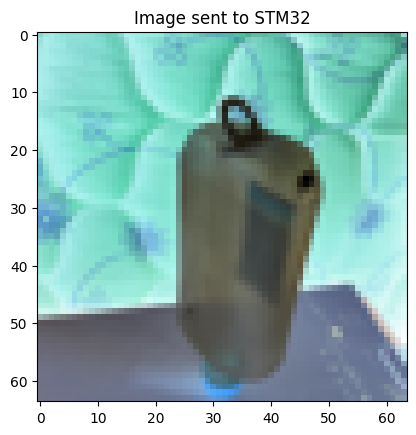

STM32:
Obtained probabilities: 
[[0. 0. 0. 1.]]
Model prediction is [3] with probability [1.]

***** Prediction matches with y_test label
---------



Elapsed time: 8.113148212432861 s

All inferences have been effected

Number of error reported according to y_test: 0


In [21]:
if __name__ == '__main__':

    tf.autograph.set_verbosity(0)
    nb_inference = 1
    with serial.Serial("COM6", 115200, timeout=1) as ser:
        chrono = timer("Chrono")
    
        # Model available for board's results comparaison
        used_model = "model.h5"
    
        # X_test and Y_test dataset available for inference
        path_xtest = "x_test.npy"
        path_ytest = "y_test_onehot.npy" # we should use one hot vector for y          
        i = 0
        nb_error = 0
        errored_elem = []
    
        chrono.tic()
        while(i < nb_inference):
            print ("\n\n----------- Inference "+str(i)+" requested: -----------\n")
    
            t1 = MODEL_set(used_model)
            t1.set_dataset_from_xtest(path_xtest, path_ytest)
            t1.pick_rand_value_from_xtest()
            #t1.get_prediction()
            print ("\nSending to STM32...\n")
    
            send_NN_inputs_to_STM32(t1, ser)
            print("---------\n")
    
            if(t1.match_pred_label() == 1):
                nb_error += 1
                errored_elem.append(t1)
    
            i = i + 1
    
            del t1
    
        print ('\n')
        chrono.toc()
        print ("\nAll inferences have been effected")
        print ("\nNumber of error reported according to y_test: "+str(nb_error))
        ser.close()
